In [1]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf

def load_image_dataset(base_dir, img_size=(224, 224)):
    """
    Load images from subdirectories into a single dataset.
    
    Parameters:
    base_dir (str): Path to the base directory containing class subdirectories
    img_size (tuple): Target size for the images (default: (224, 224))
    
    Returns:
    tuple: (X_data, y_data, label_map)
    """
    
    # Lists to store images and labels
    images = []
    labels = []
    
    # Create a mapping of directory names to numeric labels
    label_map = {}
    for idx, class_name in enumerate(sorted(os.listdir(base_dir))):
        label_map[class_name] = idx
    
    # Load images and labels
    for class_name in sorted(os.listdir(base_dir)):
        class_dir = os.path.join(base_dir, class_name)
        if not os.path.isdir(class_dir):
            continue
            
        class_label = label_map[class_name]
        
        for img_name in os.listdir(class_dir):
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(class_dir, img_name)
                try:
                    # Load and preprocess image
                    img = Image.open(img_path)
                    img = img.convert('RGB')  # Convert to RGB format
                    img = img.resize(img_size)  # Resize image
                    img_array = np.array(img) / 255.0  # Normalize pixel values
                    
                    images.append(img_array)
                    labels.append(class_label)
                except Exception as e:
                    print(f"Error loading image {img_path}: {str(e)}")
    
    # Convert lists to numpy arrays
    X_data = np.array(images)
    y_data = np.array(labels)
    
    return X_data, y_data, label_map


E0000 00:00:1738648685.295688      10 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:230


In [2]:
# Example usage
if __name__ == "__main__":
    # Replace with your directory path
    base_directory = "/kaggle/input/traffic/traffic_Data/DATA"
    
    # Load the dataset
    X_data, y_data, label_map = load_image_dataset(
        base_directory,
        img_size=(224, 224)
    )
    
    # Print dataset information
    print(f"Number of samples: {len(X_data)}")
    print(f"Number of classes: {len(label_map)}")
    print(f"Class mapping: {label_map}")
    
    # Optional: Convert to TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((X_data, y_data))

Number of samples: 4170
Number of classes: 58
Class mapping: {'0': 0, '1': 1, '10': 2, '11': 3, '12': 4, '13': 5, '14': 6, '15': 7, '16': 8, '17': 9, '18': 10, '19': 11, '2': 12, '20': 13, '21': 14, '22': 15, '23': 16, '24': 17, '25': 18, '26': 19, '27': 20, '28': 21, '29': 22, '3': 23, '30': 24, '31': 25, '32': 26, '33': 27, '34': 28, '35': 29, '36': 30, '37': 31, '38': 32, '39': 33, '4': 34, '40': 35, '41': 36, '42': 37, '43': 38, '44': 39, '45': 40, '46': 41, '47': 42, '48': 43, '49': 44, '5': 45, '50': 46, '51': 47, '52': 48, '53': 49, '54': 50, '55': 51, '56': 52, '57': 53, '6': 54, '7': 55, '8': 56, '9': 57}


I0000 00:00:1738648731.548371      10 service.cc:148] XLA service 0x571926d4c3c0 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738648731.548419      10 service.cc:156]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1738648731.548424      10 service.cc:156]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1738648731.548427      10 service.cc:156]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1738648731.548430      10 service.cc:156]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1738648731.548432      10 service.cc:156]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1738648731.548435      10 service.cc:156]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1738648731.548438      10 service.cc:156]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1738648731.548441      10 service.cc:156]   StreamExecutor device (7): TPU, 2a886c8


In [3]:
import numpy as np
import cv2
from PIL import Image

def extract_edge_features(X_data):
    features_1 = []

    for img_array in X_data:
        # Convert the image array to uint8 before processing
        img = (np.array(img_array) * 255).astype(np.uint8)
        
        # Convert to grayscale using PIL (more efficient)
        gray_image = Image.fromarray(img).convert("L")

        # Convert grayscale image back to NumPy array for OpenCV processing
        gray_array = np.array(gray_image)

        # Apply the Sobel operator in the X direction
        sobel_x = cv2.Sobel(gray_array, cv2.CV_64F, 1, 0, ksize=3)

        # Apply the Sobel operator in the Y direction
        sobel_y = cv2.Sobel(gray_array, cv2.CV_64F, 0, 1, ksize=3)

        # Calculate the magnitude of the gradients
        magnitude = np.sqrt(sobel_x**2 + sobel_y**2)

        # Normalize to 0-255, avoid division by zero
        max_magnitude = np.max(magnitude)
        if max_magnitude > 0:
            magnitude = np.uint8(255 * magnitude / max_magnitude)
        else:
            magnitude = np.uint8(magnitude)  # If max is 0, no edges exist

        # Store the processed image in features_1
        features_1.append(magnitude)

    return np.array(features_1)  

In [4]:
import numpy as np
import cv2
from PIL import Image

def extract_line_features(X_data):
    features_2 = []

    for img_array in X_data:
        # Convert the image array to uint8 before processing
        img = (np.array(img_array) * 255).astype(np.uint8)
        
        # Convert to grayscale using PIL
        gray_image = Image.fromarray(img).convert("L")

        # Convert grayscale image back to NumPy array for OpenCV processing
        gray_array = np.array(gray_image)

        # Find edges using Canny edge detector
        edges = cv2.Canny(gray_array, 50, 200)

        # Detect lines using Hough Line Transform
        lines = cv2.HoughLinesP(edges, 1, np.pi/180, 68, minLineLength=15, maxLineGap=250)

        # Convert grayscale image to BGR (for colored line drawing)
        line_image = cv2.cvtColor(gray_array, cv2.COLOR_GRAY2BGR)

        # Draw detected lines on the image
        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]
                cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 3)  # Blue lines

        # Store the processed image in features_2
        features_2.append(line_image)

    return np.array(features_2) 

In [5]:
import numpy as np
import cv2
from PIL import Image

def extract_contour_features(X_data):
    features_3 = []

    for img_array in X_data:
        # Convert the image array to uint8 before processing
        img = (np.array(img_array) * 255).astype(np.uint8)
        
        # Convert to grayscale using PIL
        gray_image = Image.fromarray(img).convert("L")

        # Convert grayscale image back to NumPy array for OpenCV processing
        gray_array = np.array(gray_image)

        # STEP 1: Apply GaussianBlur to reduce noise
        blurred = cv2.GaussianBlur(gray_array, (5, 5), 0)

        # STEP 2: Use Canny edge detector
        edges = cv2.Canny(blurred, 50, 150)

        # STEP 3: Find contours
        contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        # Create a color copy of the image for contour drawing (in BGR format)
        contour_image = cv2.cvtColor(gray_array, cv2.COLOR_GRAY2BGR)

        # Draw contours in green (0, 255, 0) with thickness of 1
        cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 1)

        # Store the processed contour image in features_3
        features_3.append(contour_image)

    return np.array(features_3)  

In [6]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def extract_histogram_features(X_data):
    features_4 = []

    for img_array in X_data:
        # Convert to uint8 and load image
        img = (np.array(img_array) * 255).astype(np.uint8)

        # Calculate RGB histograms
        blue_color = cv2.calcHist([img], [0], None, [256], [0, 256])
        green_color = cv2.calcHist([img], [1], None, [256], [0, 256])
        red_color = cv2.calcHist([img], [2], None, [256], [0, 256])

        # Store the histograms in features_4 (RGB histograms)
        features_4.append((blue_color, green_color, red_color))

    return np.array(features_4)  

In [7]:
features_1 = extract_edge_features(X_data)
features_2 = extract_line_features(X_data)
features_3 = extract_contour_features(X_data)
features_4 = extract_histogram_features(X_data)

In [8]:
!pip install tqdm


[notice] A new release of pip is available: 23.0.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [13]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.base import clone
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

def combine_and_train_svm(features_1, features_2, features_3, features_4, labels, 
                         val_size=0.2, random_state=42, max_iter=100, 
                         early_stopping_rounds=3, tolerance=0.001,
                         n_components_pixel=0.95, n_components_hist=0.95):
    """
    Combine features and train optimized SVM model with early stopping.
    
    Parameters:
    - n_components_pixel: PCA variance ratio to retain for pixel features
    - n_components_hist: PCA variance ratio to retain for histogram features
    """
    
    # Get the number of samples
    n_samples = len(features_1)
    
    # Flatten the pixel-based features
    f1_flat = features_1.reshape(n_samples, -1)
    f2_flat = features_2.reshape(n_samples, -1)
    f3_flat = features_3.reshape(n_samples, -1)
    
    # Flatten histogram features
    features_B = features_4.squeeze().reshape(n_samples, -1)
    
    # Combine pixel-based features
    features_A = np.concatenate([f1_flat, f2_flat, f3_flat], axis=1)
    
    print("\nOriginal feature dimensions:")
    print(f"Pixel features (A): {features_A.shape}")
    print(f"Histogram features (B): {features_B.shape}")
    
    # Scale features
    scaler_A = StandardScaler()
    scaler_B = StandardScaler()
    
    features_A_scaled = scaler_A.fit_transform(features_A)
    features_B_scaled = scaler_B.fit_transform(features_B)
    
    # Apply PCA for dimensionality reduction
    print("\nApplying PCA...")
    pca_A = PCA(n_components=n_components_pixel, random_state=random_state)
    pca_B = PCA(n_components=n_components_hist, random_state=random_state)
    
    features_A_reduced = pca_A.fit_transform(features_A_scaled)
    features_B_reduced = pca_B.fit_transform(features_B_scaled)
    
    print(f"Reduced pixel features: {features_A_reduced.shape}")
    print(f"Reduced histogram features: {features_B_reduced.shape}")
    print(f"Variance retained (pixel): {sum(pca_A.explained_variance_ratio_):.3f}")
    print(f"Variance retained (hist): {sum(pca_B.explained_variance_ratio_):.3f}")
    
    # Split the data
    X_train_A, X_val_A, X_train_B, X_val_B, y_train, y_val = train_test_split(
        features_A_reduced, features_B_reduced, labels,
        test_size=val_size,
        random_state=random_state,
        stratify=labels
    )
    
    # Combine reduced features
    X_train = np.concatenate([X_train_A, X_train_B], axis=1)
    X_val = np.concatenate([X_val_A, X_val_B], axis=1)
    
    print(f"\nFinal training set shape: {X_train.shape}")
    
    # Get unique classes
    classes = np.unique(labels)
    
    # Initialize SGD-based SVM model
    model = SGDClassifier(
        loss='hinge',  # SVM loss
        penalty='l2',
        alpha=0.0001,  # Equivalent to C in standard SVM
        max_iter=1,    # We'll handle iterations manually
        learning_rate='optimal',
        random_state=random_state,
        tol=tolerance
    )
    
    # Initial fit with classes
    model.partial_fit(X_train, y_train, classes=classes)
    
    # Training with early stopping
    best_val_score = 0
    rounds_without_improvement = 0
    best_model = None
    history = {'train_acc': [], 'val_acc': []}
    
    print("\nStarting Training:")
    pbar = tqdm(range(max_iter))
    
    for iteration in pbar:
        # Partial fit for one epoch
        model.partial_fit(X_train, y_train)
        
        # Calculate scores
        train_score = accuracy_score(y_train, model.predict(X_train))
        val_score = accuracy_score(y_val, model.predict(X_val))
        
        # Store scores
        history['train_acc'].append(train_score)
        history['val_acc'].append(val_score)
        
        # Update progress bar
        pbar.set_postfix({
            'Train Acc': f'{train_score:.4f}',
            'Val Acc': f'{val_score:.4f}',
            'No Improve': rounds_without_improvement
        })
        
        # Check for improvement
        if val_score > (best_val_score + tolerance):
            best_val_score = val_score
            rounds_without_improvement = 0
            best_model = clone(model)
        else:
            rounds_without_improvement += 1
            
        # Early stopping check
        if rounds_without_improvement >= early_stopping_rounds:
            print(f"\nEarly stopping at iteration {iteration}")
            break
    
    # Plot training history
    plt.figure(figsize=(10, 6))
    plt.plot(history['train_acc'], label='Training Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.title('Training History')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    
    return best_model, pca_A, pca_B, scaler_A, scaler_B, history


Original feature dimensions:
Pixel features (A): (4170, 351232)
Histogram features (B): (4170, 768)

Applying PCA...
Reduced pixel features: (4170, 967)
Reduced histogram features: (4170, 139)
Variance retained (pixel): 0.950
Variance retained (hist): 0.951

Final training set shape: (3336, 1106)

Starting Training:


 42%|████▏     | 42/100 [00:17<00:22,  2.58it/s, Train Acc=0.9964, Val Acc=0.9568, No Improve=2]


Early stopping at iteration 42


 42%|████▏     | 42/100 [00:17<00:24,  2.34it/s, Train Acc=0.9964, Val Acc=0.9568, No Improve=2]


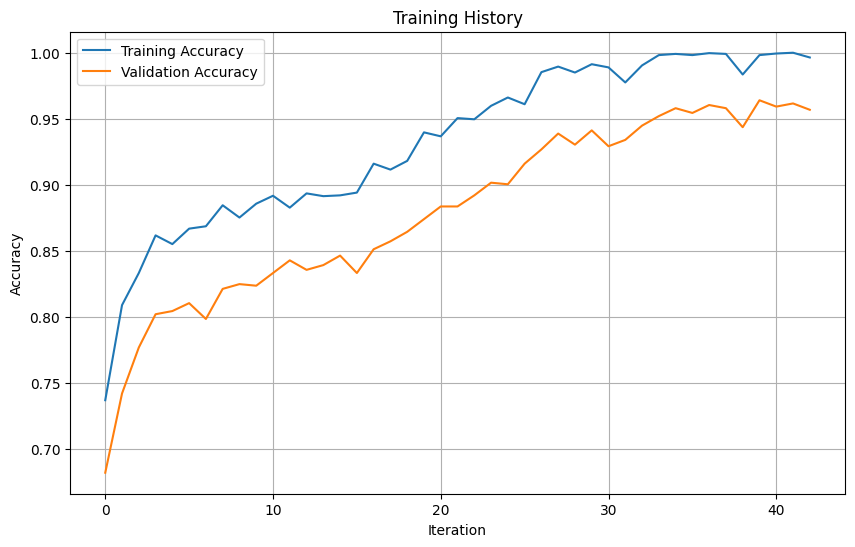


Final Classification Report:


NotFittedError: This SGDClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [15]:
model, pca_A, pca_B, scaler_A, scaler_B, history = combine_and_train_svm(
    features_1, features_2, features_3, features_4, labels=y_data
)